In [28]:
# import libraries
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import feature

from sklearn.model_selection import train_test_split

In [3]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [201]:
images = []
images_paths = os.listdir('dataset/flooded')

# sort images
images_paths.sort(key=lambda x: int(x.split('.')[0]))

# load images
for file in images_paths:
    image = Image.open('dataset/flooded/' + file)
    image = image.resize((256, 256))
    image = np.array(image)
    images.append(image)

## Kmeans

In [56]:
def segment_kmenas(image, k=2):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    pixel_vals = np.float32(image.reshape(-1, image.shape[2]))
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))

    return segmented_image, centers


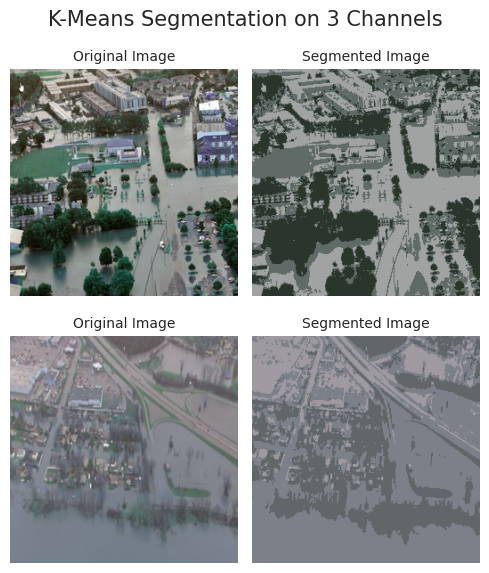

In [222]:
imgs_num = 2
fig, ax = plt.subplots(imgs_num, 2, figsize=(imgs_num * 2.5, imgs_num * 3))
# get 4 random images
index = np.random.randint(0, len(images), imgs_num)
for i in range(imgs_num):
    # blue = np.expand_dims(images[index[i]][:, :, 2], axis=2)
    mask, centers = segment_kmenas(images[index[i]], k=3)

    ax[i, 0].imshow(images[index[i]].astype("uint8"))
    ax[i, 0].set_title('Original Image', fontsize=10)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('Segmented Image', fontsize=10)
    ax[i, 1].axis("off")
plt.suptitle('K-Means Segmentation on 3 Channels', fontsize=15)
plt.tight_layout()
plt.show()

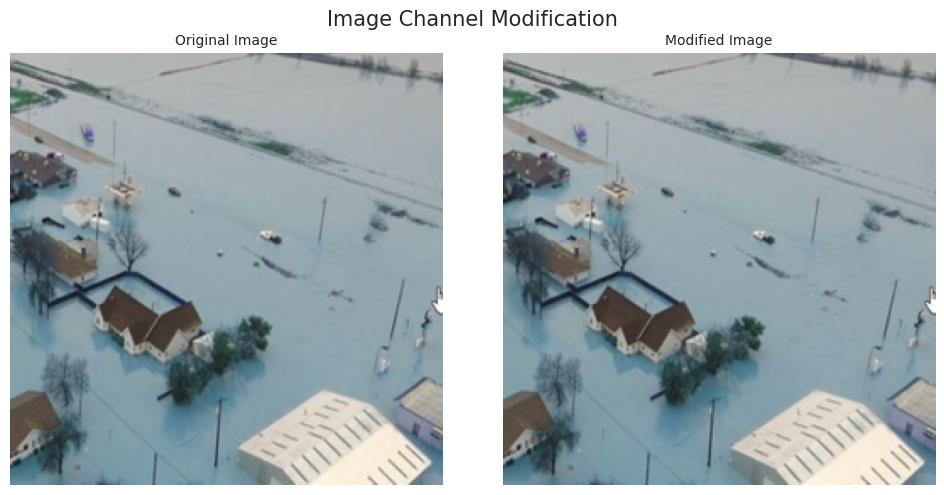

In [239]:
test_image = images[2].copy()
image = test_image.copy()
hsv_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)

average = hsv_image.mean(axis=0).mean(axis=0)

if not average[0] > 80 or not average[0] < 140:
    test_image[:, :, 0] = image[:, :, 2]
    test_image[:, :, 2] = image[:, :, 0]

# show image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=10)
ax[0].axis("off")
ax[1].imshow(test_image)
ax[1].set_title('Modified Image', fontsize=10)
ax[1].axis("off")
plt.suptitle('Image Channel Modification', fontsize=15)
plt.tight_layout()

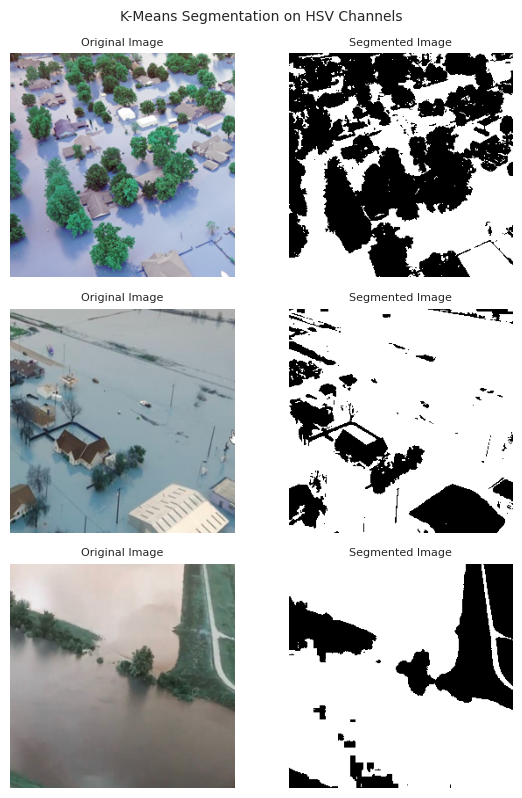

In [251]:
imgs_num = 3
fig, ax = plt.subplots(imgs_num, 2, figsize=(imgs_num * 2, imgs_num * 2.7))
index = [0, 2, 9, 5]
for i in range(imgs_num):
    image = images[index[i]].copy()
    tmp_image = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    average = hsv.mean(axis=0).mean(axis=0)

    if not average[0] > 70 or not average[0] < 140:
        image[:, :, 0] = tmp_image[:, :, 2]
        image[:, :, 2] = tmp_image[:, :, 0]

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    sig, centers = segment_kmenas(hsv, 4)
    filtered_centers = centers[(centers[:, 0] > 90) & 
                                (centers[:, 0] < 150) &
                                (centers[:, 1] > 25) ]
    if len(filtered_centers) == 0:
        filtered_centers = centers[(centers[:, 0] > 90) & 
                                (centers[:, 0] < 140)]

    mask = np.zeros((image.shape[0], image.shape[1], 1))

    # make pixels with a color in filtered_centers white
    for cluster_index in range(len(filtered_centers)):
        current_mask = np.where(sig == filtered_centers[cluster_index], 255, 0)
        mask = mask + current_mask
    mask = np.where(mask > 0, 255, 0)
    # mask = np.where(mask == filtered_centers[cluster_index], 255, 0)
    ax[i, 0].imshow(tmp_image.astype("uint8"))
    ax[i, 0].set_title('Original Image', fontsize=8)
    ax[i, 0].axis("off")
    ax[i, 1].imshow(mask)
    ax[i, 1].set_title('Segmented Image',  fontsize=8)
    ax[i, 1].axis("off")

plt.suptitle('K-Means Segmentation on HSV Channels', fontsize=10)
plt.tight_layout()
plt.show()